In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk, buttord, butter

In [3]:
def mine_dft(matrix):
    N = 1024
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    if len(matrix.shape) == 1:
        return np.dot(e, matrix)
    
    output = np.zeros(matrix.shape, dtype=np.cdouble)
    for i in range(matrix.shape[1]):
        output[:, i] = np.dot(e, matrix[:,i])
        
    return output

In [4]:
# Nacteni zvukoveho souboru, s - pole s hodnoty signalu, fs - vzorkovaci frekvence
s, fs = sf.read('../audio/xvagne10.wav')
# Vytvoreni pole se setejnou delkou jako signal, hodnota odpovida casu vyskytu kazdeho prvku.
t = np.arange(s.size) / fs
# Delka v sekundach
print(t[-1])
# Pocet vzorku
print(s.size)

2.310375
36967


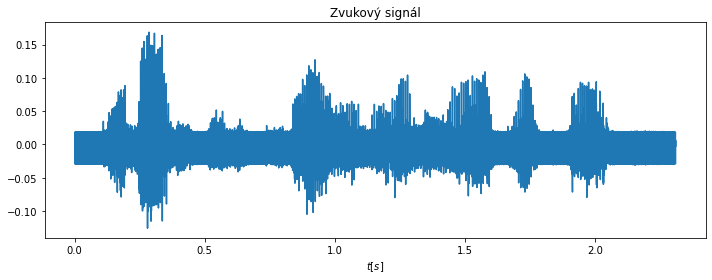

In [5]:
# Zobrazeni puvodni signalu v casu
plt.figure(figsize=(10,4))
plt.plot(t, s)

plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')

plt.tight_layout()

In [6]:
mean = np.mean(s)
max_abs = np.amax(np.abs(s))
# Ustredneni 
s = s - mean
# Normalizovani, od -1 do 1
s = s / max_abs

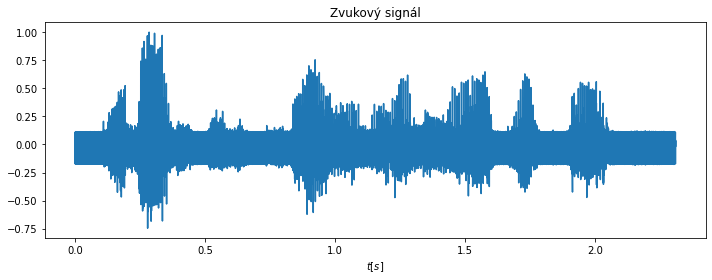

In [7]:
# Zobrazeni ustredneneho a normalizovaneho signalu v casu
plt.figure(figsize=(10,4))
plt.plot(t, s)

plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')

plt.tight_layout()

In [8]:
start_point = 1.4 * fs
N = 1024 # segment/frame length
shift = 512

In [9]:
out_matrix = np.zeros((int(np.ceil(s.size / shift)), N))

In [10]:
for i in range(int(np.floor(s.size / shift))):
    pos = i * shift
    if s[pos:pos + N].shape[0] < N:
        out_matrix[i][0:s[pos:pos + N].shape[0]] = s[pos:pos + N]
    else:
        out_matrix[i] = s[pos:pos + N] 

out_matrix = np.transpose(out_matrix)
print(out_matrix.shape)

(1024, 73)


In [11]:
seg = out_matrix[:, 16]
seg_spec = mine_dft(seg)
seg_spec_ref = np.fft.fft(seg)

'Everything OK' if np.allclose(seg_spec, seg_spec_ref) else 'Big oof'

'Everything OK'

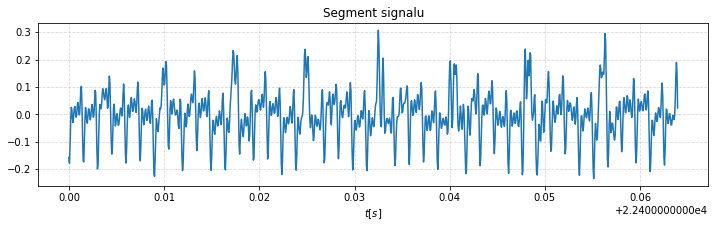

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(seg.size) / fs + start_point, seg)
plt.xlabel('$t[s]$')
plt.title('Segment signalu')
plt.grid(alpha=0.5, linestyle='--')
plt.show()

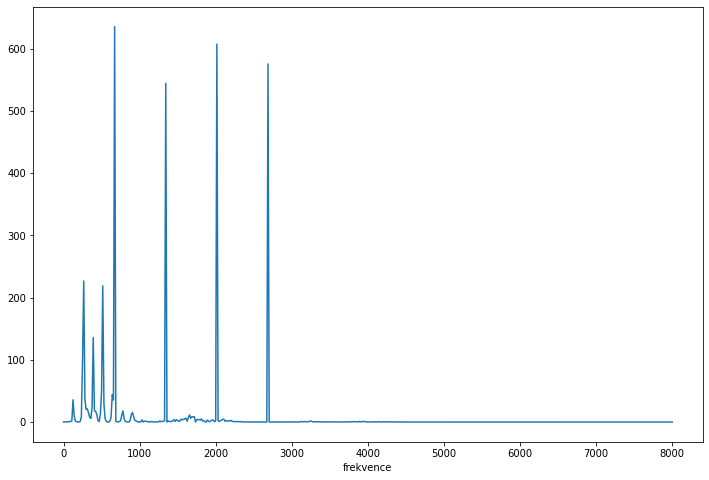

671.875


In [13]:
dft_res = mine_dft(out_matrix)
PSD = np.abs(dft_res[:, 16])[:N//2+1]**2 # power spectral density

f_axis = np.arange(513)
plt.figure(figsize=(12, 8))
plt.plot(f_axis / 1024 * fs, PSD)
plt.xlabel('frekvence')
plt.show()

print(np.argmax(PSD) / 1024 * fs)

In [14]:
# Spectogram
f, t, sgr = spectrogram(s, fs)
sgr_log = 10 * np.log10(np.abs(sgr)**2)

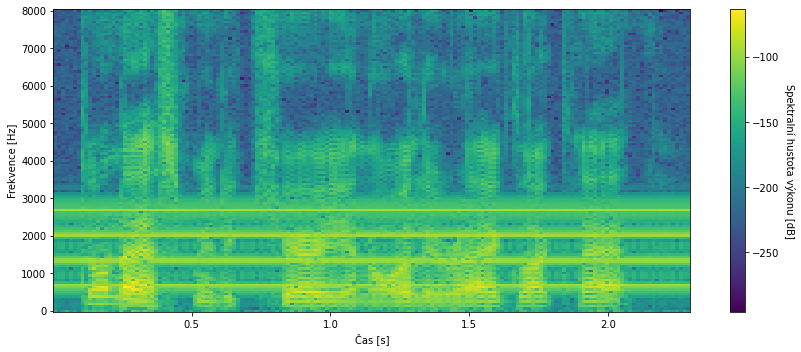

In [15]:
plt.figure(figsize=(12,5))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

In [16]:
sorted_PSD = np.argsort(PSD) / 1024 * fs
print(sorted_PSD[-4:])

[1343.75  2687.5   2015.625  671.875]


In [17]:
f_1 = np.argmax(PSD) / 1024 * fs
f_2 = f_1 * 2
f_3 = f_1 * 3
f_4 = f_1 * 4

print('f_1 OK') if f_1 == sorted_PSD[-1] else 'f_1 oof'
print('f_2 OK') if f_2 == sorted_PSD[-4] else 'f_2 oof'
print('f_3 OK') if f_3 == sorted_PSD[-2] else 'f_3 oof'
print('f_4 OK') if f_4 == sorted_PSD[-3] else 'f_4 oof'

f_1 OK
f_2 OK
f_3 OK
f_4 OK


In [18]:
# Generovani cosinus vln
# Vzorkovaci frekvence
gen_fs = 16000
# Interval který vzorkovat
gen_ts = 1.0 / gen_fs
gen_t = np.arange(0, 2.310375, gen_ts)

output = np.cos(2 * np.pi * f_1 * gen_t)
output += np.cos(2 * np.pi * f_2 * gen_t)
output += np.cos(2 * np.pi * f_3 * gen_t)
output += np.cos(2 * np.pi * f_4 * gen_t)

mean = np.mean(output)
max_abs = np.amax(np.abs(output))
# Ustredneni 
output = output - mean
# Normalizovani, od -1 do 1
output = output / max_abs

In [19]:
sf.write('../audio/4cos.wav', output, gen_fs)

In [20]:
# Spectogram of generated signal
cos4_s, cos4_fs = sf.read('../audio/4cos.wav')
cos4_f, cos4_t, cos4_sgr = spectrogram(cos4_s, cos4_fs)
cos4_sgr_log = 10 * np.log10(np.abs(cos4_sgr)**2)

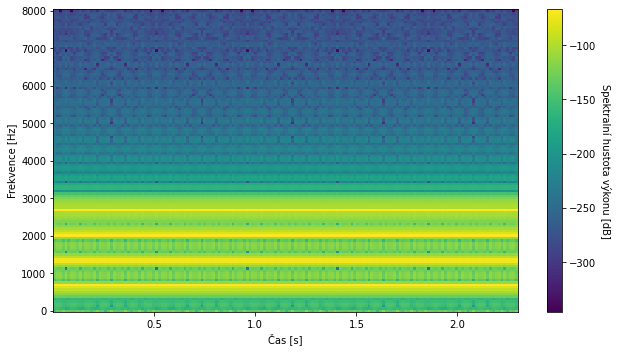

In [21]:
plt.figure(figsize=(9,5))
plt.pcolormesh(cos4_t,cos4_f,cos4_sgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

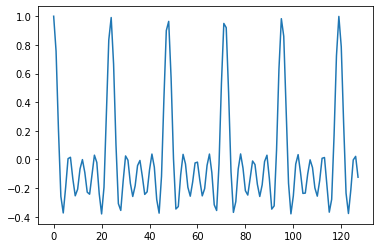

In [22]:
plt.plot(output[:128])
plt.show()

[  0.9381124   -7.24526501  24.73628843 -48.7463241   60.63439804
 -48.7463241   24.73628843  -7.24526501   0.9381124 ]
[  1.          -7.59990727  25.53356389 -49.51733289  60.61629453
 -47.9605276   23.95328641  -6.90541044   0.88005487]


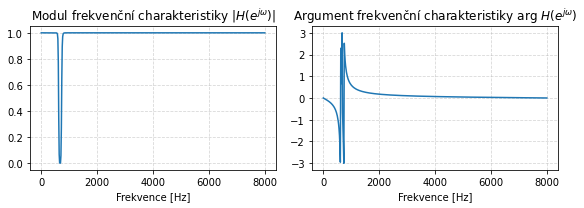

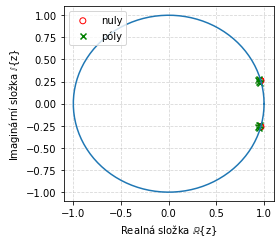

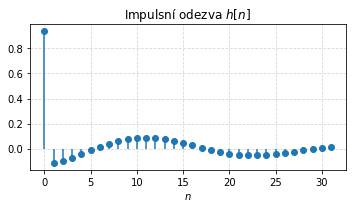

In [23]:
N, Wn = buttord([f_1 - 65, f_1 + 65], [f_1 - 15, f_1 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a, fs=16000)

_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w, np.abs(h))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w, np.angle(h))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

# nuly, poly
z, p, k = tf2zpk(b, a)

# stability
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 
'' if is_stable else 'Filtr neni stabilni.'

plt.figure(figsize=(4,3.5))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)] # jednotkovy impuls
h = lfilter(b, a, imp)
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

print(b)
print(a)

[  0.93686738  -6.47533738  20.53079245 -38.75953437  47.53955774
 -38.75953437  20.53079245  -6.47533738   0.93686738]
[  1.          -6.79902591  21.2061643  -39.38441724  47.52367684
 -38.12087996  19.86731577  -6.1654204    0.87772049]


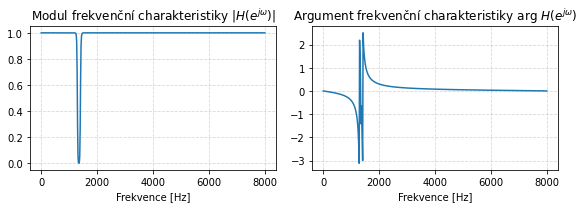

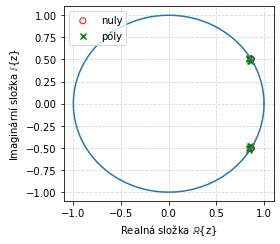

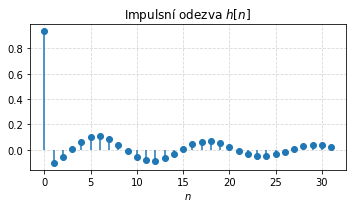

In [24]:
N, Wn = buttord([f_2 - 65, f_2 + 65], [f_2 - 15, f_2 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a, fs=16000)

_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w, np.abs(h))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w, np.angle(h))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

# nuly, poly
z, p, k = tf2zpk(b, a)

# stability
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 
'' if is_stable else 'Filtr neni stabilni.'

plt.figure(figsize=(4,3.5))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)]
h = lfilter(b, a, imp)

plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

print(b)
print(a)

[  0.93642685  -5.26428022  14.84346944 -26.19082836  31.4674619
 -26.19082836  14.84346944  -5.26428022   0.93642685]
[  1.          -5.5293702   15.33491166 -26.61510171  31.45544197
 -25.755197    14.36000559  -5.01054825   0.87689525]


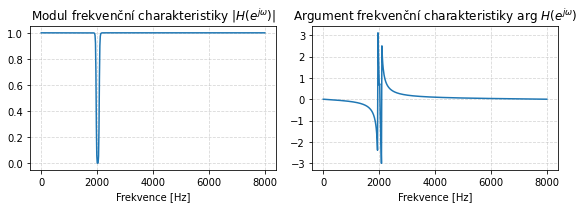

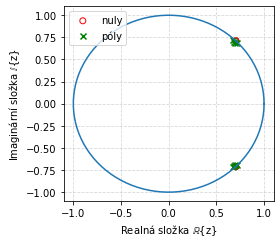

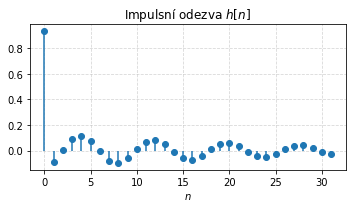

In [25]:
N, Wn = buttord([f_3 - 65, f_3 + 65], [f_3 - 15, f_3 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a, fs=16000)

_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w, np.abs(h))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w, np.angle(h))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

# nuly, poly
z, p, k = tf2zpk(b, a)

# stability
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 
'' if is_stable else 'Filtr neni stabilni.'

plt.figure(figsize=(4,3.5))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)] # jednotkovy impuls
h = lfilter(b, a, imp)
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

print(b)
print(a)

[  0.93620146  -3.69093316   9.20155909 -14.65830118  17.41419544
 -14.65830118   9.20155909  -3.69093316   0.93620146]
[  1.          -3.87749132   9.50678676 -14.8957809   17.40617497
 -14.41279956   8.90028163  -3.51239691   0.87647318]


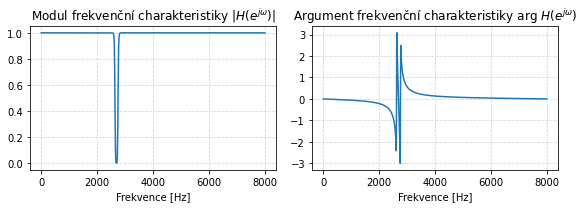

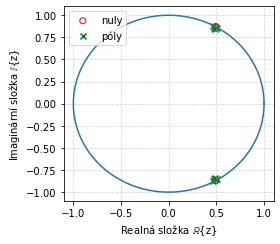

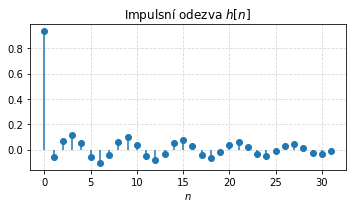

In [26]:
N, Wn = buttord([f_4 - 65, f_4 + 65], [f_4 - 15, f_4 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)

w, h = freqz(b, a, fs=16000)

_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w, np.abs(h))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w, np.angle(h))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()


# nuly, poly
z, p, k = tf2zpk(b, a)

# stability
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 
'' if is_stable else 'Filtr neni stabilni.'

plt.figure(figsize=(4,3.5))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)] # jednotkovy impuls
h = lfilter(b, a, imp)
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

print(b)
print(a)

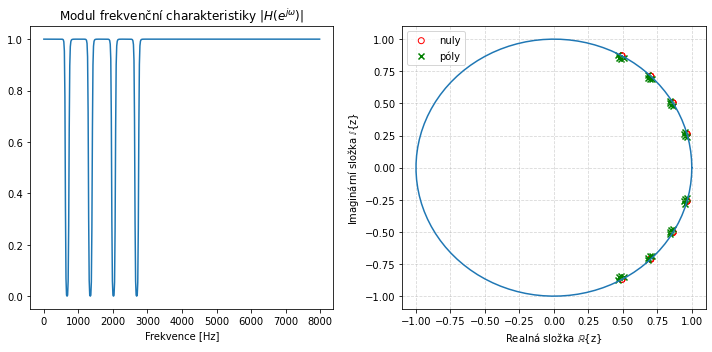

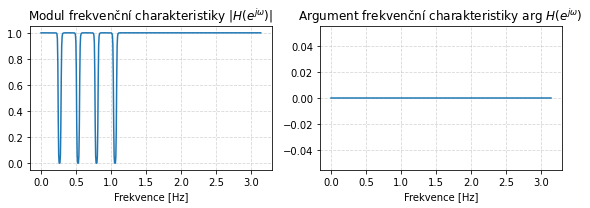

In [27]:
_, ax = plt.subplots(1, 2, figsize=(10,5))
ang = np.linspace(0, 2*np.pi,100)
ax[1].plot(np.cos(ang), np.sin(ang))

# F_1
N, Wn = buttord([f_1 - 65, f_1 + 65], [f_1 - 15, f_1 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a)
filtered_s = lfilter(b, a, s)
#ax[0].plot(w / 2 / np.pi * fs, np.abs(h))

final_h = np.abs(h)

z, p, k = tf2zpk(b, a)
ax[1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

ax[1].grid(alpha=0.5, linestyle='--')
ax[1].legend(loc='upper left')

# F_2
N, Wn = buttord([f_2 - 65, f_2 + 65], [f_2 - 15, f_2 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a)
filtered_s = lfilter(b, a, filtered_s)
#ax[0].plot(w / 2 / np.pi * fs, np.abs(h))

final_h = final_h * np.abs(h)

z, p, k = tf2zpk(b, a)
ax[1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

# F_3
N, Wn = buttord([f_3 - 65, f_3 + 65], [f_3 - 15, f_3 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a)
filtered_s = lfilter(b, a, filtered_s)
#ax[0].plot(w / 2 / np.pi * fs, np.abs(h))

final_h = final_h * np.abs(h)

z, p, k = tf2zpk(b, a)
ax[1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

# F_4
N, Wn = buttord([f_4 - 65, f_4 + 65], [f_4 - 15, f_4 + 15], 3, 40, 16000)
b, a = butter(N, Wn, 'bandstop', fs=16000)
w, h = freqz(b, a)
filtered_s = lfilter(b, a, filtered_s)
#ax[0].plot(w / 2 / np.pi * fs, np.abs(h))

final_h = final_h * np.abs(h)
ax[0].plot(w / 2 / np.pi * fs, np.abs(final_h))

z, p, k = tf2zpk(b, a)
ax[1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')


ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[1].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.tight_layout()

_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w, np.abs(final_h))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w, np.angle(final_h))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

In [28]:
mean = np.mean(filtered_s)
max_abs = np.amax(np.abs(filtered_s))
# Ustredneni 
filtered_s = filtered_s - mean
# Normalizovani, od -1 do 1
filtered_s = filtered_s / max_abs

In [29]:
# Filtered spectogram
f, t, sgr = spectrogram(filtered_s, fs)
sgr_log = 10 * np.log10(np.abs(sgr)**2)

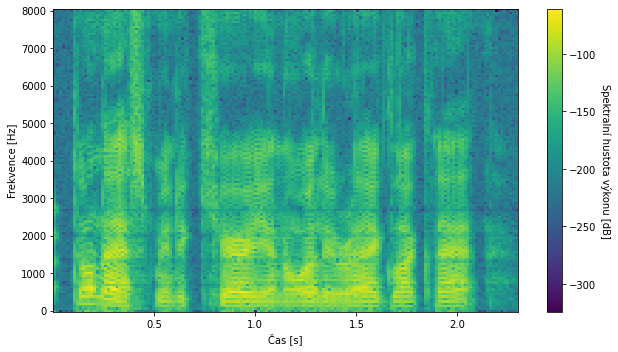

In [30]:
plt.figure(figsize=(9,5))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

In [31]:
sf.write('../audio/clean_bandstop.wav', filtered_s, fs)

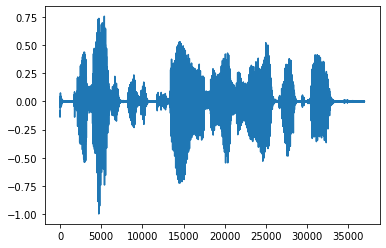

In [32]:
plt.plot(filtered_s[:])
plt.show()